In [20]:
!pip install pyreadr
import pyreadr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import IsolationForest

import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


In [21]:
 #Connnect to google drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
## Import librabries
import sys
import os

py_file_location = "/content/gdrive/My Drive/ML-exam/dataprocessing"
sys.path.append(os.path.abspath(py_file_location))

import preprocessing as pp

In [30]:
#loading hiv and tubercolosis data
data_hiv = pyreadr.read_r('/content/gdrive/MyDrive/ML-exam/dataprocessing/dataHIV.Rdata')['dfHIV']
data_tb = pyreadr.read_r('/content/gdrive/MyDrive/ML-exam/dataprocessing/dataTB.RData')['dfTB']
df_hiv, df_tb = data_hiv.copy(), data_tb.copy()
print(df_hiv.shape)
print(df_tb.shape)
data_combined = pd.concat([data_hiv, data_tb], ignore_index=True)
df_comb = data_combined.copy() 

(38567, 38)
(148720, 39)


In [31]:
# imputing nan value for ClaimSec
data_hiv.loc[data_hiv[data_hiv.aucID == "0306500000117000001"].index,"claimSec"] = 1611.80
data_hiv.loc[data_hiv[data_hiv.aucID == "0356200006718000097"].index,"claimSec"] = 424.1

# imputing nan value for bvSameBO
data_hiv.loc[data_hiv[data_hiv.aucID == "0888500000219000457"].index,"bvSameBO"] = 1

##Missing count

Text(0.5, 1.0, 'Pct of rows with most number of nans')

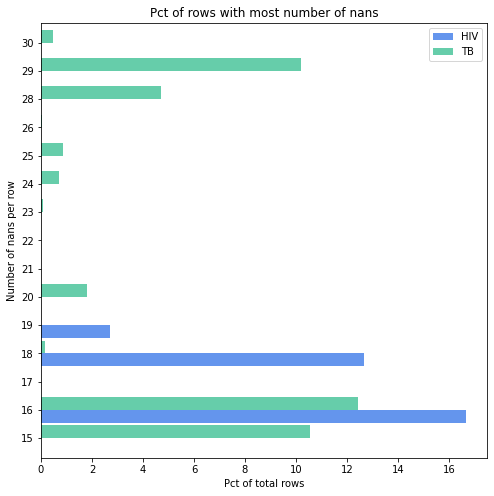

In [32]:
#Record number of missing values in each column
nan_cols_hiv = df_hiv.isna().sum().sort_values()
nan_cols_tb = df_tb.isna().sum().sort_values()

#Record number of missing values in each row
nan_rows_hiv = df_hiv.isna().sum(axis=1)
nan_rows_tb = df_tb.isna().sum(axis=1)

nan_hiv, nan_tb = nan_rows_hiv.value_counts().sort_index()/df_hiv.shape[0]*100, nan_rows_tb.value_counts().sort_index()/df_tb.shape[0]*100
nans = pd.DataFrame({'HIV': nan_hiv, 'TB': nan_tb})

ax = nans[15:].plot.barh(color={"HIV": "cornflowerblue", "TB": "mediumaquamarine"}, figsize=(8,8), width=0.9)
ax.set_xlabel("Pct of total rows")
ax.set_ylabel("Number of nans per row")
ax.set_title("Pct of rows with most number of nans")

Text(0.5, 1.0, 'Count of rows with number of participants')

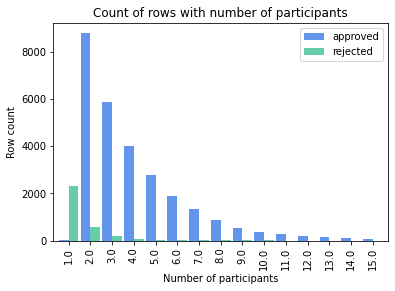

In [48]:
participants = pd.DataFrame({'approved': df_comb.nAppr1sber.value_counts().sort_index(), 
                             'rejected': df_comb.nRej1sber.value_counts().sort_index()[1:]})
ax = participants[:15].plot.bar(color={'approved':'cornflowerblue', 'rejected':'mediumaquamarine'}, width=0.9)
ax.set_xlabel("Number of participants")
ax.set_ylabel("Row count")
ax.set_title("Count of rows with number of participants")

Text(0.5, 1.0, 'Count of rows with number of participants')

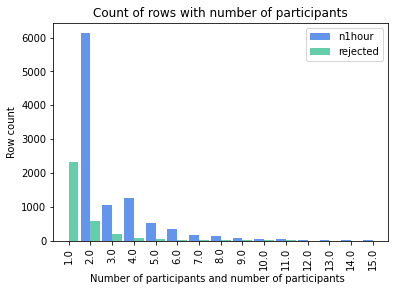

In [59]:
participants = pd.DataFrame({'n1hour': df_comb.n1hour.value_counts().sort_index()[1:], 
                             'rejected': df_comb.nRej1sber.value_counts().sort_index()[1:]})
ax = participants[:15].plot.bar(color={'n1hour':'cornflowerblue', 'rejected':'mediumaquamarine'}, width=0.9)
ax.set_xlabel("Number of participants and number of participants  ")
ax.set_ylabel("Row count")
ax.set_title("Count of rows with number of participants")

In [27]:
print('Shape of data after filtering:', df_comb.shape)
df_comb = pp.encode_variables(df_comb )
df_comb = pp.filter_data(df_comb )
print('Shape of data after filtering:', df_comb.shape)
print(df_comb.columns)

Shape of data after filtering: (187287, 39)
Shape of data after filtering: (27410, 24)
Index(['collusion', 'icpKZ', 'bvSameBO', 'combined', 'okpdLP', 'okpdMC',
       'okpdMT', 'okpdMR', 'okpdOT', 'nAppr1sber', 'nRej1sber', 'prefSmall',
       'prefLim44', 'n1hour', 'claimSec', 'aucDateOR', 'fd_CFO', 'fd_DFO',
       'fd_PFO', 'fd_SFO', 'fd_SKFO', 'fd_SZFO', 'fd_UFO', 'fd_YFO'],
      dtype='object')


In [11]:
df_comb.drop(['aucDateOR'], axis=1, inplace=True)
df_comb  = pp.scale_variables(df_comb)
print('Before handling missing values', df_comb.shape)

df_comb_removed  = df_comb.dropna().copy()
print('After handling missing values', df_comb_removed.shape)

x_train_r_hiv, x_test_r_hiv, y_train_r_hiv, y_test_r_hiv = pp.create_splits(df_comb_removed, 'collusion')

mask_hiv = pp.remove_outliers(x_train_r_hiv, 0.15)
x_train_r_hiv, y_train_r_hiv = x_train_r_hiv.iloc[mask_hiv, :], y_train_r_hiv.iloc[mask_hiv]
print('After handling missing values', x_train_r_hiv.shape)



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:1565: RuntimeWarning: invalid value encountered in subtract
  X -= self.center_


Before handling missing values (27410, 23)
After handling missing values (23359, 23)
Shape of x and y before split (23359, 22) (23359,)
Shape of x_train and x_test after split (18687, 22) (4672, 22)
Train set contains 5.875742494782469 pct ratio of collusion labels
Test set contains 5.864726027397261 pct ratio of collusion labels



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


After handling missing values (15884, 22)


#Distribution of features